## T5 MODEL
El T5 es un modelo basado en la arquitectura Transformer que fue propuesto por primera vez en el artículo "Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer" por Colin Raffel et al. en 2019.

El objetivo principal del modelo T5 es abordar diversas tareas de procesamiento de lenguaje natural (NLP) mediante un enfoque unificado de "texto a texto". Esto significa que tanto la entrada como la salida del modelo se formulan como texto en lugar de tareas específicas y predefinidas. El T5 puede realizar tareas como traducción de idiomas, generación de resúmenes, respuesta a preguntas, completado de oraciones, entre otros.

El T5 utiliza una arquitectura de Transformer, que se compone de bloques de codificador-decodificador. El codificador procesa la entrada de texto y captura su representación contextual, mientras que el decodificador genera la salida correspondiente. El modelo T5 utiliza atención multi-cabeza y capas de transformador apiladas para capturar la relación de las palabras en el texto.

El T5 se entrena mediante un enfoque de "aprendizaje por transferencia", donde se presenta una gran cantidad de datos de entrenamiento en diferentes tareas y se entrena para predecir la salida correcta. Luego, el modelo se adapta a tareas específicas ajustando los pesos durante el entrenamiento adicional.

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*QOVXAn0bx8HKGrBIXAgydw.png" width="1000"/>

In [ ]:
# Importamos las librerias necesarias
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 20.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

from transformers import (  # Importa el modelo T5
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
import torch.nn as nn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [ ]:
# Establecemos la semilla de generacion de numeros aleatorios
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

# Preparing Data

In [ ]:
from google.colab import drive
# mount your drive to colab where your dataset is present
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path in drive where the dataset is present
df = pd.read_csv("/content/drive/MyDrive/Datasets/news_headlines.csv", encoding="latin-1")
df = df.dropna()
df.head()

,article,headline
0,The logo of cryptocurrency exchange Binance di...,Binance pauses bitcoin withdrawals due to a 's...
1,"Police officers, some in riot gear, guard a gr...",White nationalist group members face riot-plan...
2,A woman walks past a row of cash machines outs...,"Lloyds to give staff 1,000 pounds to ease cost..."
3,The Amazon logo is seen outside its JFK8 distr...,"Amazon offers to share data, boost rivals to d..."
4,An unexploded shell from a multiple rocket lau...,Both sides using heavier weapons in war in Ukr...


In [ ]:
df.shape

(13445, 2)

In [ ]:
# Dividimos los datos en train, test y val
train_df, rest_df = train_test_split(df, test_size=0.2)
test_df, val_df = train_test_split(rest_df, test_size=0.5)

train_df.shape, test_df.shape, val_df.shape

((10756, 2), (1344, 2), (1345, 2))

In [ ]:
# Cargamos el tokenizador
MODEL_NAME = "t5-base" # T5-Base (220 million parameters)

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length=512) # Carga los pesos preentrenados del tokenizador

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

In [ ]:
# Calculamos la cantidad de token para articulo y titular, de los datos de entrenamiento
article_token_counts, headline_token_counts = [], [] # almacenar las cantidades de tokens para cada artículo y titular

for _, row in train_df.iterrows():
    article_token_count = len(tokenizer.encode(row["article"])) # Utiliza el tokenizador para codificar el artículo
    article_token_counts.append(article_token_count)

    headline_token_count = len(tokenizer.encode(row["headline"])) # Utiliza el tokenizador para codificar el titular
    headline_token_counts.append(headline_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (746 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Longitud máxima de los textos en las columnas "article" y "headline"
df["article"].str.len().max(), df["headline"].str.len().max()

(33246, 157)

Text(0.5, 1.0, 'headline text token counts')

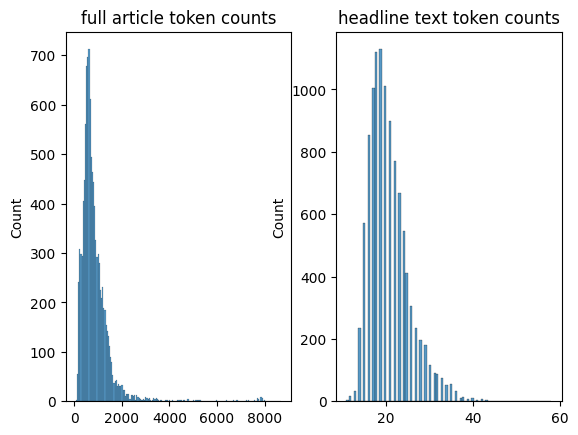

In [ ]:
# Distribución de las cantidades de tokens en los artículos y titulares
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(article_token_counts, ax=ax1)
ax1.set_title("full article token counts")

sns.histplot(headline_token_counts, ax=ax2)
ax2.set_title("headline text token counts")

In [ ]:
example = df.iloc[0]["article"]
example

'The logo of cryptocurrency exchange Binance displayed on a smartphone with the word "cancelled" on a computer screen in the background.Budrul Chukrut | SOPA Images | LightRocket via Getty ImagesBinance said Monday that it is temporarily pausing bitcoin withdrawals "due to a stuck transaction causing a backlog."At first, Binance founder and CEO Changpeng Zhao said in a tweet that the issue would be fixed within 30 minutes. But he later amended that to say, "Likely this is going to take a bit longer to fix than my initial estimate." He added that, "[t]his is only impacting the Bitcoin network," and that holders "can still withdraw Bitcoin on other networks like BEP-20.""Funds are SAFU," he added. The acronym stands for "secure asset fund for users," which is a fund the company established in 2018 to help safeguard users.The news comes as bitcoin tumbled more than 10% on Monday, breaking below $24,000 and sinking to the lowest level since December 2020.The largest cryptocurrency has been

In [ ]:
# Visualizacion del tokenizado
tokenizer.tokenize(example)

['▁The',
 '▁logo',
 '▁of',
 '▁cryptocurrency',
 '▁exchange',
 '▁Bin',
 'ance',
 '▁displayed',
 '▁on',
 '▁',
 'a',
 '▁smartphone',
 '▁with',
 '▁the',
 '▁word',
 '▁"',
 'can',
 'cel',
 'led',
 '"',
 '▁on',
 '▁',
 'a',
 '▁computer',
 '▁screen',
 '▁in',
 '▁the',
 '▁background',
 '.',
 'Bu',
 'd',
 'rul',
 '▁Chu',
 'k',
 'rut',
 '▁|',
 '▁SO',
 'PA',
 '▁Images',
 '▁|',
 '▁Light',
 'Rock',
 'e',
 't',
 '▁via',
 '▁G',
 'etty',
 '▁Images',
 'B',
 'in',
 'ance',
 '▁said',
 '▁Monday',
 '▁that',
 '▁it',
 '▁is',
 '▁temporarily',
 '▁pa',
 'using',
 '▁bitcoin',
 '▁withdrawal',
 's',
 '▁"',
 'du',
 'e',
 '▁to',
 '▁',
 'a',
 '▁stuck',
 '▁transaction',
 '▁',
 'causing',
 '▁',
 'a',
 '▁back',
 'log',
 '."',
 'A',
 't',
 '▁first',
 ',',
 '▁Bin',
 'ance',
 '▁founder',
 '▁and',
 '▁CEO',
 '▁Chang',
 'pen',
 'g',
 '▁Zhao',
 '▁said',
 '▁in',
 '▁',
 'a',
 '▁tweet',
 '▁that',
 '▁the',
 '▁issue',
 '▁would',
 '▁be',
 '▁fixed',
 '▁within',
 '▁30',
 '▁minutes',
 '.',
 '▁But',
 '▁',
 'he',
 '▁later',
 '▁amended',
 '▁

In [ ]:
# Visualizacion del codificado(encoder)
tokenizer.encode(example)

[37,
 3554,
 13,
 19432,
 2509,
 7617,
 663,
 6099,
 30,
 3,
 9,
 5626,
 28,
 8,
 1448,
 96,
 1608,
 7125,
 1361,
 121,
 30,
 3,
 9,
 1218,
 1641,
 16,
 8,
 2458,
 5,
 7793,
 26,
 5155,
 16636,
 157,
 6830,
 1820,
 5055,
 3965,
 15180,
 1820,
 2892,
 23349,
 15,
 17,
 1009,
 350,
 16142,
 15180,
 279,
 77,
 663,
 243,
 2089,
 24,
 34,
 19,
 18223,
 2576,
 9381,
 16623,
 11905,
 7,
 96,
 1259,
 15,
 12,
 3,
 9,
 6229,
 5878,
 3,
 5885,
 3,
 9,
 223,
 2152,
 535,
 188,
 17,
 166,
 6,
 7617,
 663,
 7174,
 11,
 4071,
 24187,
 3208,
 122,
 30680,
 243,
 16,
 3,
 9,
 10657,
 24,
 8,
 962,
 133,
 36,
 3599,
 441,
 604,
 676,
 5,
 299,
 3,
 88,
 865,
 21012,
 24,
 12,
 497,
 6,
 96,
 434,
 5208,
 120,
 48,
 19,
 352,
 12,
 240,
 3,
 9,
 720,
 1200,
 12,
 2210,
 145,
 82,
 2332,
 7037,
 535,
 216,
 974,
 24,
 6,
 96,
 6306,
 17,
 908,
 10193,
 19,
 163,
 1113,
 53,
 8,
 9310,
 1229,
 976,
 11,
 24,
 14733,
 96,
 1608,
 341,
 14510,
 9310,
 30,
 119,
 5275,
 114,
 6554,
 345,
 7988,
 535,
 121,


In [ ]:
# preparamos los datos en un formato adecuado para el modelo T5
class NewsHeadlineDataset(Dataset):

    def __init__(
        self,
        data: pd.DataFrame, # El DataFrame que contiene los datos, con columnas "article" y "headline"
        tokenizer: T5Tokenizer, # El tokenizador T5 utilizado para codificar los textos
        article_max_token_len: int = 512, # La longitud máxima de tokens para los artículos
        headline_max_token_len: int = 128 # La longitud máxima de tokens para los titulares
    ):

        self.tokenizer = tokenizer
        self.data = data
        self.article_max_token_len = article_max_token_len
        self.headline_max_token_len = headline_max_token_len

    def __len__(self): # Longitud total del conjunto de datos
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index] # Obtiene un elemento del conjunto de datos en la posición index

        article = data_row["article"]

        # Utiliza el tokenizador para codificar tanto el artículo como el titular,
        # con las opciones de longitud máxima, relleno y truncamiento especificadas.
        article_encoding = tokenizer(
            article,
            max_length=self.article_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        headline_encoding = tokenizer(
            data_row["headline"],
            max_length=self.headline_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        # Ajusta las etiquetas para que coincidan con los identificadores de entrada del titular y
        # asigna el valor de padding (-100) donde sea necesario
        labels = headline_encoding["input_ids"]
        labels[labels == 0] = -100

        # Devuelve un diccionario con la información necesaria
        return dict(
            article=article,
            headline=data_row["headline"],
            article_input_ids=article_encoding["input_ids"].flatten(), # "aplanar" la estructura y convertirla en una secuencia unidimensional.
            article_attention_mask=article_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=headline_encoding["attention_mask"].flatten()
        )

In [ ]:
# Organizamos y preparamos los datos para el entrenamiento
class NewsHeadlineDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_df: pd.DataFrame, # Dataframe de entrenamiento
        test_df: pd.DataFrame, # Dataframe de prueba
        val_df: pd.DataFrame, # Dataframe de validacion
        tokenizer: T5Tokenizer, # Tokenizador T5 utilizado para codificar los textos
        batch_size: int = 2, # Tamaño del lote para los conjuntos de datos
        article_max_token_len: int = 512, # Longitudes máximas de tokens para articulos
        headline_max_token_len: int = 128 # Longitudes máximas de tokens para titulares
    ):

        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.article_max_token_len = article_max_token_len
        self.headline_max_token_len = headline_max_token_len

    # Crea instancias de la clase NewsHeadlineDataset
    # para los conjuntos de entrenamiento, prueba y validación utilizando los DataFrames proporcionados
    def setup(self, stage=None):
        self.train_dataset = NewsHeadlineDataset(
            self.train_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

        self.test_dataset = NewsHeadlineDataset(
            self.test_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

        self.val_dataset = NewsHeadlineDataset(
            self.val_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

    # Estos metodos devuelven un DataLoader configurado para el conjunto de datos correspondiente.
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True, # used for training
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

# Model Building

In [ ]:
# Definimos hiperparametros para el entrenamiento
N_EPOCHS = 3    #10
BATCH_SIZE = 2  #8

data_module = NewsHeadlineDataModule(train_df, test_df, val_df, tokenizer, batch_size=BATCH_SIZE)

In [ ]:
class NewsHeadlineModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        # Realizamos transfer learning, luego durante el entrenamiento del modelo(NewsHeadlineModel)
        # los pesos preentrenados se usaran como punto de partida y el
        # modelo se ajusta a los datos especificos
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True) # Inicializa el modelo T5 preentrenado para generación condicional
        #self.val_loss = []
        self.val_loss_epoch = []

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        # si tenemos etiquetas, tendremos decoder_attenttion_mask, que se calcula a partir de la codificación de resumen y las etiquetas

        output = self.model(
            input_ids, # Identificadores de tokens de entrada del artículo
            attention_mask=attention_mask, # Máscara de atención para el artículo
            labels=labels, # Identificadores de tokens de salida esperados
            decoder_attention_mask=decoder_attention_mask # Máscara de atención para el decodificador (utilizado durante la generación de texto)
        )

        # Calcula la salida del modelo y devuelve tanto la pérdida como los logits
        return output.loss, output.logits

    # Se define el paso de entrenamiento
    # Realizamos fine-tuning
    def training_step(self, batch, batch_idx):
        # Extraer datos del lote
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        # Pasar los datos al modelo para obtener las salidas
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=labels_attention_mask
        )

        # Calcular la pérdida
        loss = outputs.loss

        # Registrar la pérdida para seguimiento y visualización
        self.log("train_loss", loss.item(), prog_bar=True, logger=True)

        # Devolver la pérdida para retropropagación y actualización de pesos
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=labels_attention_mask
        )

        loss = outputs.loss
        logits = outputs.logits

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_logits_sample", torch.tensor(logits.view(-1).detach().cpu().numpy()[:10]).mean())
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=labels_attention_mask
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
model = NewsHeadlineModel()
print(model)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

NewsHeadlineModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_f

In [ ]:
# Opciones necesarias para el entrenamiento del modelo
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EPOCHS,
    accelerator="auto"
    #gpus=1
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 5378: 'val_loss' reached 1.48118 (best 1.48118), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 10756: 'val_loss' reached 1.40315 (best 1.40315), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 16134: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
# path to the checkpoint needs to be provided here
custom_path = "/content/drive/MyDrive/Datasets/best-checkpoint.ckpt"

trained_model = NewsHeadlineModel.load_from_checkpoint(custom_path)

trained_model.freeze()

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.1 to v2.1.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/Datasets/best-checkpoint.ckpt`


<img src="http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png" width="1000"/>

In [ ]:
def generate_headline(text):
  # Codifica el texto utilizando el tokenizador
  text_encoding = tokenizer(
      text,
      max_length=512,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors="pt"
  )

  # Mueve los tensores a la misma GPU/Dispositivo en el que se encuentra el modelo entrenado
  input_ids = text_encoding["input_ids"].to(trained_model.device)
  attention_mask = text_encoding["attention_mask"].to(trained_model.device)

  # Genera el titular utilizando el modelo
  generated_ids = trained_model.model.generate(
      input_ids=input_ids,
      attention_mask=attention_mask,
      max_length=150,
      num_beams=2, # beam search
      repetition_penalty=2.5,
      length_penalty=1.0,
      early_stopping=True # Para acelerar el proceso
  )

  # Decodifica los identificadores generados para obtener el titular final
  preds = [
      tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
      for gen_id in generated_ids
  ]

  # Combina los titulares generados en un solo string
  return "".join(preds)

## Prediction examples

In [ ]:
sample_row = val_df.iloc[0]
text = sample_row["article"]

In [ ]:
print(len(text.split()))
text

910


'Former Japanese prime minister Shinzo Abe lies on the ground after apparent shooting during an election campaign for the July 10, 2022 Upper House election, in Nara, western Japan July 8, 2022. in this photo taken by Kyodo. Mandatory credit Kyodo via REUTERS NARA, Japan, July 8 (Reuters) - Former Prime Minister Shinzo Abe, Japan\'s longest-serving leader, was in grave condition on Friday after being shot while campaigning for a parliamentary election, with media saying a man opened fire with an apparently homemade gun.Prime Minister Fumio Kishida condemned the shooting in the western city of Nara in the "strongest terms" while Japanese people and world leaders expressed shock at the assassination attempt in a country in which political violence is rare and guns are tightly controlled.Struggling to keep his emotions in check, Kishida said Abe, 67, was in grave condition.Register now for FREE unlimited access to Reuters.com"Everything that can be done is being done to revive him. I\'m p

In [ ]:
sample_row["headline"]

'Shinzo Abe in "grave condition" after being shot during Japan election campaign.'

In [ ]:
generate_headline(text)

"Japan's Abe in 'grave condition' after being shot while campaigning for election."

In [ ]:
sample_row = val_df.iloc[10]
text = sample_row["article"]

In [ ]:
print(len(text.split()))
text

654


'Register now for FREE unlimited access to Reuters.comTAIPEI, Aug 2 (Reuters) - Taiwan is preparing its air-raid shelters as rising tension with China and Russia\'s invasion of Ukraine raise new fears about the possibility of a Chinese attack on the democratic island.China considers Taiwan its territory and has increased military activity in the air and seas around it. Taiwan vows to defend itself and has made strengthening its defences a priority, with regular military and civil defence drills. read more The preparations include designating shelters where people can take cover if Chinese missiles start flying in, not in purpose-built bunkers but in underground spaces like basement car parks, the subway system and subterranean shopping centres.Register now for FREE unlimited access to Reuters.comThe capital of Taipei has more than 4,600 such shelters that can accommodate some 12 million people, more than four times its population.Harmony Wu, 18, was surprised to learn that an undergrou

In [ ]:
sample_row["headline"]

'From subway stations to shopping malls, Taiwan prepares its air-raid shelters.'

In [ ]:
generate_headline(text)

'Taiwan prepares its air-raid shelters as tensions grow with China.'

In [ ]:
sample_row = val_df.iloc[15]
text = sample_row["article"]

In [ ]:
print(len(text.split()))
text

716


'U.S. June 14, 2022 / 11:26 AM / CBS/AP Yellowstone flooding prompts evacuations Yellowstone flooding washes out roads, prompts evacuations 00:56 A child and two adults are missing after they were swept away in a drainage ditch in Milwaukee following severe thunderstorms that brought heavy rains and damaging winds to a wide swath of the Midwest and parts of the South, authorities said.Witnesses told police the 11-year-old boy fell about 6:30 p.m. Monday into the ditch, which carries water through a tunnel to the Kinnickinnic River. According to police, two men, ages 34 and 37, entered the water in an attempt to rescue the boy, but all three were swept away."In that tunnel, we have no idea what was going on in that tunnel," said Assistant Fire Chief DeWayne Smoots. Divers have been searching for an 11-year-old child and two Milwaukee men who were swept into a drainage tunnel near 27th and Loomis after heavy rains Monday. The search has now been suspended until daylight. MORE HERE: https

In [ ]:
sample_row["headline"]

'Boy, 2 adults missing after being swept away in drainage ditch following severe storms in Milwaukee.'

In [ ]:
generate_headline(text)

'11-year-old boy and 2 adults missing after falling into drainage ditch in Milwaukee.'

In [ ]:
text = '“Cuando me vaya, si quieres llorar, mejor regalame una sonrisa, no quiero llanto, quiero alegría, recordare siempre, mi despedida”, cantaba a voz en cuello Franz Chuquimia, líder y vocalista de la agrupación, Jach’a Mallku, en una de sus últimas presentaciones en Oruro. El lunes esa inconfundible voz se apagó y este miércoles fue despedido en el cementerio Jardín de la ciudad de La Paz.“Mi papá no está muerto, está con nosotros, aquí, dándonos la fuerza que necesitamos, agradecer a todos por estar aquí.  Y papito hubieras querido que nada de esto termine, que continúe y vamos a seguir con tu legado. Mira tanta gente que ha venido a verte, que te quiere”, logró esbozar a manera de discurso Sebastián, uno de los hijos de Franz, quien ahora sustituirá a su padre en el conjunto.“Es la primera vez que piso el escenario, la segunda vez que agarro el micrófono y lo hago por mi papá”, confesó el muchacho.El municipio paceño facilitó el teatro Alberto Saavedra Pérez para la despedida final al cantautor nacional que recorrió todos los escenarios. Nacido en La Paz en 1969 y a sus 25 años fundó Jach’a Mallku. Desde entonces no hizo otra cosa que cosechar éxitos, en el occidente del país y en países vecinos.En la despedida, los músicos de su agrupación interpretaron algunos de sus éxitos como “Por quererte más” y “Morenada al amor”. Los asistentes al velorio se sumaron a los cantos entre aplausos y lágrimas. “Siempre vivirás en nuestros corazones”, “vuela alto compadre”, “que viva Jach’a Mallku”, “gracias, maestro Franz por tus enseñanzas”, expresaron los músicos de la agrupación, para luego interpretar la reconocida morenada Cecilia.A las 13:00 concluyó el velorio. Una multitudinaria caravana, en compañía de la banda municipal Eduardo Caba, recorrió las calles del centro paceño en una marcha fúnebre hasta el Cementerio Jardín.'

In [ ]:
generate_headline(text)

'La vida de Franz Chuquimia se despedidó en la ciudad de Oruro.'